during the ETLT
1. combine both motorist and sgcarmart
2. names to be extracted -> brand and model 
3. fetch data from API
4. combine both APIs together to get 1 dataset
5. derive the vehicle classes
6. fetch the COE prices

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from google.cloud import bigquery
pd.set_option('display.max_columns', None)

In [89]:
# read dataset first
# data = pd.read_csv('../Datasets/final_combined_dataset.csv')

path_to_private_key = 'is3107-418903-a6116d294003.json'
bigquery_client = bigquery.Client.from_service_account_json(json_credentials_path=path_to_private_key)

sql = """
        SELECT * FROM `is3107-418903.final.carsCombinedFinal`
        """
data = bigquery_client.query(sql).to_dataframe()

In [90]:
data = data.dropna()

In [91]:
data

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,accessories,model_make_id,make,model_trim,model_year,model_body,model_seats,model_weight_kg,model_engine_fuel,model_engine_cyl,model_drive,model_transmission_type,model_fuel_cap_l,vehicle_class,premium,month,date_listed,bidding_no
0,1,1600.0,17800.0,25380.0,140000.0,84.0,0.70,15758.0,10758.0,"Cheapest SUV in the Market! High paper Value, ...",618,subaru,23492,2015,SUV,5,1454.875283,regular unleaded,flat 4,all wheel drive,continuously variable-speed automatic,60.1815,Category A,94010,2024-04,2024-04-20,2
2,1,1600.0,31900.0,14960.0,83000.0,84.0,0.51,18541.0,18541.0,Front mid size monitor screen with reverse cam...,618,subaru,23492,2015,SUV,5,1454.875283,regular unleaded,flat 4,all wheel drive,continuously variable-speed automatic,60.1815,Category A,89000,2024-04,2024-04-12,1
3,1,1600.0,24000.0,15310.0,164147.0,84.0,0.18,16922.0,11922.0,"Multi-function steering wheel, keyless entry s...",618,subaru,23492,2015,SUV,5,1454.875283,regular unleaded,flat 4,all wheel drive,continuously variable-speed automatic,60.1815,Category A,94010,2024-04,2024-04-18,2
4,1,1600.0,33800.0,15800.0,113060.0,84.0,0.56,18249.0,18249.0,"Leather seats, sports rims, multi-function ste...",618,subaru,23492,2015,SUV,5,1454.875283,regular unleaded,flat 4,all wheel drive,continuously variable-speed automatic,60.1815,Category A,94010,2024-04,2024-04-16,2
5,1,1600.0,52000.0,13280.0,80864.0,84.0,3.41,13486.0,13486.0,"AWD, keyless start/stop, reverse camera/sensor...",79,subaru,17838,2017,Hatchback,5,1353.741497,regular unleaded,flat 4,all wheel drive,5-speed manual,49.9620,Category A,89000,2024-04,2024-04-03,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,6,2687.0,110800.0,24410.0,162000.0,180.0,4.54,67671.0,67671.0,"Carbon fibre steering wheel, brembo front and ...",581,porsche,39848,2008,Coupe,2,1299.773243,Gasoline,6,Rear,Manual,63.9665,Category B,96010,2024-03,2024-03-15,1
8715,6,2687.0,93800.0,21200.0,95000.0,180.0,4.42,62000.0,62000.0,"Dual electric seats, Memory seat, Android Play...",581,porsche,39848,2008,Coupe,2,1299.773243,Gasoline,6,Rear,Manual,63.9665,Category B,101334,2024-04,2024-04-07,1
8717,6,2687.0,119999.0,28040.0,84000.0,180.0,4.28,82062.0,82062.0,All In Stock Condition. All Wear And Tear Repa...,581,porsche,39848,2008,Coupe,2,1299.773243,Gasoline,6,Rear,Manual,63.9665,Category B,102001,2024-04,2024-04-18,2
8719,6,2687.0,90000.0,24920.0,156000.0,180.0,3.61,77010.0,84711.0,"LTA approve wide body kit, carbon parts, after...",581,porsche,39848,2008,Coupe,2,1299.773243,Gasoline,6,Rear,Manual,63.9665,Category B,96010,2024-03,2024-03-06,1


# Data Processing

In [92]:
# checking the data types
data.dtypes

owners                       Int64
eng_cap                    float64
price                      float64
depreciation               float64
mileage                    float64
power                      float64
coe_left                   float64
omv                        float64
arf                        float64
accessories                 object
model_make_id               object
make                        object
model_trim                  object
model_year                   Int64
model_body                  object
model_seats                  Int64
model_weight_kg            float64
model_engine_fuel           object
model_engine_cyl            object
model_drive                 object
model_transmission_type     object
model_fuel_cap_l           float64
vehicle_class               object
premium                      Int64
month                       object
date_listed                 object
bidding_no                   Int64
dtype: object

In [93]:
# # converting to integers
# data['model_year'] = data['model_year'].astype("Int64")
# data['model_seats'] = data['model_seats'].astype("Int64")

# # 2dp 
# data['model_weight_kg'] = data['model_weight_kg'].round(2)
# data['model_fuel_cap_l'] = data['model_fuel_cap_l'].round(2)

# # converting to datetime
# data['reg_date'] = pd.to_datetime(data['reg_date'])

# drop model trim
columns_to_drop = ['model_trim', 'accessories', 'model_make_id', 'vehicle_class', 'month', 'date_listed', 'bidding_no']
data = data.drop(columns=columns_to_drop)

## Encoding Model Body

In [94]:
# before replacing data 
print(data['model_body'].value_counts())

model_body
Sedan                           1869
SUV                             1525
Hatchback                       1039
Coupe                            613
Convertible                      487
Compact Cars                     301
Midsize Cars                     170
Sport Utility Vehicles           157
Minivan                          117
Large Cars                        53
Wagon                             37
Two Seaters                       33
Mini Compact Cars                 33
Subcompact Cars                   22
Station Wagon                     22
Roadster                           5
Small Station Wagons               3
Crossover                          2
Not Available                      2
Small Sport Utility Vehicles       1
Name: count, dtype: int64


In [95]:
data.iloc[0]['model_body'].lower()

'suv'

In [96]:
# encode model_body

for index, row in data.iterrows():
    row['model_body'] = row['model_body'].lower()
    if 'sport' in row['model_body']:
        data.at[index, 'model_body'] ='SUV'
    elif 'compact' in row['model_body'] or 'subcompact' in row['model_body']:
        data.at[index, 'model_body'] ='Compact Cars'
    elif 'manual' in row['model_body']:
        data.at[index, 'model_body'] ='Manual'
    elif 'wagon' in row['model_body']:
        data.at[index, 'model_body'] ='Wagon'
        
# after replacing data 
print(data['model_body'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_body'], drop_first=True)

model_body
Sedan            1869
SUV              1683
Hatchback        1039
Coupe             613
Convertible       487
Compact Cars      356
Midsize Cars      170
Minivan           117
Wagon              62
Large Cars         53
Two Seaters        33
Roadster            5
Crossover           2
Not Available       2
Name: count, dtype: int64


## Encoding Model Transmission Type

In [97]:
# before replacing data 
print(data['model_transmission_type'].value_counts())

model_transmission_type
8-speed shiftable automatic              1244
Manual                                    744
Automatic                                 719
7-speed automated manual                  693
continuously variable-speed automatic     615
6-speed shiftable automatic               577
6-speed manual                            564
9-speed shiftable automatic               417
7-speed shiftable automatic               266
Automated Manual                          133
6-speed automated manual                  117
5-speed manual                            109
8-speed automatic                          61
6-speed automatic                          56
8-speed automated manual                   48
4-speed automatic                          48
7-speed manual                             23
CVT                                        16
10-speed shiftable automatic               16
7-speed automatic                          13
7-speed automatic                           4
Single Spe

In [98]:
data['model_transmission_type'].dtype

dtype('O')

In [99]:
# encode transmission_type
for index, row in data.iterrows():
    row['model_transmission_type'] = row['model_transmission_type'].lower()
    if 'continuously' in row['model_transmission_type'] or 'single Speed' in row['model_transmission_type'] or 'cvt' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='CVT'
    elif 'automatic' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Automatic'
    elif 'manual' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Manual'
    elif 'automated manual' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Automated Manual'
    else:
        data.at[index, 'model_transmission_type'] ='Others'

# after replacing data
print(data['model_transmission_type'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_transmission_type'], drop_first=True)


model_transmission_type
Automatic    3423
Manual       2434
CVT           631
Others          3
Name: count, dtype: int64


## Encoding Model Drive

In [100]:
# before replacing data 
print(data['model_drive'].value_counts())

model_drive
front wheel drive    1956
all wheel drive      1665
rear wheel drive      964
Front                 458
Front Wheel Driv      388
Rear                  304
Rear Wheel Drive      303
AWD                   146
four wheel drive      109
All Wheel Drive        89
4WD                    74
AWD                    23
Four Wheel Drive       12
Name: count, dtype: int64


In [101]:
#encode model_drive
for index, row in data.iterrows():
    row['model_drive'] = row['model_drive'].lower()
    if 'all' in row['model_drive'] or '4wd' in row['model_drive'] or 'awd' in row['model_drive'] or 'four' in row['model_drive']:
        data.at[index, 'model_drive'] ='All Wheel Drive'
    elif 'front' in row['model_drive']:
        data.at[index, 'model_drive'] ='Front Wheel Drive'
    elif 'rear' in row['model_drive']:
        data.at[index, 'model_drive'] ='Rear Wheel Drive'
    else:
        data.at[index, 'model_drive'] ='Others'
        

# after replacing data
print(data['model_drive'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_drive'], drop_first=True)

model_drive
Front Wheel Drive    2802
All Wheel Drive      2118
Rear Wheel Drive     1571
Name: count, dtype: int64


## Encoding Model Engine Fuel

In [102]:
# before replacing data 
print(data['model_engine_fuel'].value_counts())

model_engine_fuel
premium unleaded (required)                     2049
regular unleaded                                1448
premium unleaded (recommended)                  1111
Gasoline                                         685
Premium Unleaded (Required)                      327
Regular Unleaded                                 236
Gasoline - Premium                               210
Diesel                                           142
Premium Unleaded (Recommended)                   130
diesel fuel                                       57
Premium                                           32
Gasoline / Electric Hybrid                        29
flex-fuel (premium unleaded recommended/E85)      19
flex-fuel (premium unleaded required/E85)         10
Diesel / Electric Hybrid                           3
Electric                                           3
Name: count, dtype: int64


In [103]:
# encode transmission_type
for index, row in data.iterrows():
    row['model_engine_fuel'] = row['model_engine_fuel'].lower()
    if 'premium' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Premium'
    elif 'regular' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Regular'
    elif 'hybrid' in row['model_engine_fuel'] or 'gasoline' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Hybrid'
    elif 'gasoline' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Regular'
    elif 'diesel' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Diesel'
    elif 'electric' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Electric'
    else:
        print(row['model_engine_fuel'])
        data.at[index, 'model_engine_fuel'] ='Others'

# after replacing data

print(data['model_engine_fuel'].value_counts())


# nominal encoding
data = pd.get_dummies(data, columns=['model_engine_fuel'], drop_first=True)


model_engine_fuel
Premium     3888
Regular     1684
Hybrid       717
Diesel       199
Electric       3
Name: count, dtype: int64


## Encoding Model Engine Cylinders

In [104]:
# before replacing data 
print(data['model_engine_cyl'].value_counts())

model_engine_cyl
I4        3193
4         1092
V6         599
V8         347
6          347
flat 4     235
8          204
I6         161
12          57
10          43
flat 6      39
5           35
W12         35
I3          32
V10         21
I5          17
V12         15
2           13
3            6
Name: count, dtype: int64


In [105]:
# convert all values to string first
data['model_engine_cyl'] = data['model_engine_cyl'].astype("string")

for index, row in data.iterrows():
    row['model_engine_cyl'] = row['model_engine_cyl'].lower()
    if '2' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='2'
    elif '3' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='3'
    elif '4' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='4'
    elif '5' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='5'
    elif '6' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='6'
    elif '8' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='8'
    elif '10' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='10'
    elif '12' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='12'

    

#convert back to int
data['model_engine_cyl'] = data['model_engine_cyl'].astype("Int64")
# after replacing data
print(data['model_engine_cyl'].value_counts())

model_engine_cyl
4     4520
6     1146
8      551
2      120
10      64
5       52
3       38
Name: count, dtype: Int64


# Change reg_date into numerical data

In [106]:
data['years_since_reg'] = 0

for index, row in data.iterrows():
    year = row['model_year']
    data.at[index, 'years_since_reg'] = 2024-year

data = data.drop(columns=['model_year'])

In [107]:
data

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,make,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,premium,model_body_Convertible,model_body_Coupe,model_body_Crossover,model_body_Hatchback,model_body_Large Cars,model_body_Midsize Cars,model_body_Minivan,model_body_Not Available,model_body_Roadster,model_body_SUV,model_body_Sedan,model_body_Two Seaters,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_transmission_type_Others,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg
0,1,1600.0,17800.0,25380.0,140000.0,84.0,0.70,15758.0,10758.0,subaru,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9
2,1,1600.0,31900.0,14960.0,83000.0,84.0,0.51,18541.0,18541.0,subaru,5,1454.875283,4,60.1815,89000,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9
3,1,1600.0,24000.0,15310.0,164147.0,84.0,0.18,16922.0,11922.0,subaru,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9
4,1,1600.0,33800.0,15800.0,113060.0,84.0,0.56,18249.0,18249.0,subaru,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9
5,1,1600.0,52000.0,13280.0,80864.0,84.0,3.41,13486.0,13486.0,subaru,5,1353.741497,4,49.9620,89000,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,6,2687.0,110800.0,24410.0,162000.0,180.0,4.54,67671.0,67671.0,porsche,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16
8715,6,2687.0,93800.0,21200.0,95000.0,180.0,4.42,62000.0,62000.0,porsche,2,1299.773243,6,63.9665,101334,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16
8717,6,2687.0,119999.0,28040.0,84000.0,180.0,4.28,82062.0,82062.0,porsche,2,1299.773243,6,63.9665,102001,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16
8719,6,2687.0,90000.0,24920.0,156000.0,180.0,3.61,77010.0,84711.0,porsche,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16


## Encoding Model
we will classify the car models into 3 categories

In [108]:
brands = {
    'budget' : ['Chevrolet', 'Citroen', 'Fiat', 'Ford', 'Honda', 'Hyundai', 'Kia', 'Mazda', 'Mitsubishi', 'Nissan', 'Peugeot', 'Renault', 'Skoda', 'Ssangyong', 'Subaru', 'Suzuki', 'Toyota', 'Daihatsu', 'Proton'],
    'mid' : ['Alfa Romeo', 'Chrysler', 'Infiniti', 'MINI', 'Opel', 'Saab', 'Volkswagen', 'Audi', 'BMW', 'Jaguar', 'Jeep', 'Lexus', 'Lotus', 'Mercedes-Benz', 'Mercedes Benz', 'Mitsuoka', 'Volvo', 'Dodge Journey'],
    'exotic' : ['Aston Martin', 'Ferrari', 'Lamborghini', 'McLaren', 'Bentley', 'Land-Rover', 'Land Rover', 'Maserati', 'Porsche', 'Rolls-Royce', 'Rolls Royce']
}

In [109]:
data['brands'] = "others"

for index, row in data.iterrows():
    model = str(row['make'])
    for group, brand_list in brands.items():
        for brand in brand_list:
            if brand.lower() in model.lower():
                data.at[index, 'brands'] = group


In [110]:
data

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,make,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,premium,model_body_Convertible,model_body_Coupe,model_body_Crossover,model_body_Hatchback,model_body_Large Cars,model_body_Midsize Cars,model_body_Minivan,model_body_Not Available,model_body_Roadster,model_body_SUV,model_body_Sedan,model_body_Two Seaters,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_transmission_type_Others,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands
0,1,1600.0,17800.0,25380.0,140000.0,84.0,0.70,15758.0,10758.0,subaru,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,budget
2,1,1600.0,31900.0,14960.0,83000.0,84.0,0.51,18541.0,18541.0,subaru,5,1454.875283,4,60.1815,89000,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,budget
3,1,1600.0,24000.0,15310.0,164147.0,84.0,0.18,16922.0,11922.0,subaru,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,budget
4,1,1600.0,33800.0,15800.0,113060.0,84.0,0.56,18249.0,18249.0,subaru,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,budget
5,1,1600.0,52000.0,13280.0,80864.0,84.0,3.41,13486.0,13486.0,subaru,5,1353.741497,4,49.9620,89000,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,7,budget
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,6,2687.0,110800.0,24410.0,162000.0,180.0,4.54,67671.0,67671.0,porsche,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,exotic
8715,6,2687.0,93800.0,21200.0,95000.0,180.0,4.42,62000.0,62000.0,porsche,2,1299.773243,6,63.9665,101334,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,exotic
8717,6,2687.0,119999.0,28040.0,84000.0,180.0,4.28,82062.0,82062.0,porsche,2,1299.773243,6,63.9665,102001,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,exotic
8719,6,2687.0,90000.0,24920.0,156000.0,180.0,3.61,77010.0,84711.0,porsche,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,exotic


In [111]:
print(data['brands'].value_counts())

brands
mid       3575
budget    2023
exotic     797
others      96
Name: count, dtype: int64


In [112]:
# ordinal encoding of the car brands
ordinal_mapping = {
    'budget': 1,
    'mid': 2,
    'exotic' : 3,
    'others' : 1.5
}
data['brands'] = data['brands'].map(ordinal_mapping)
data = data.drop(columns=['make'])

# Exploratory Data Analysis

Text(0.5, 1.0, 'Correlation Plot with Features')

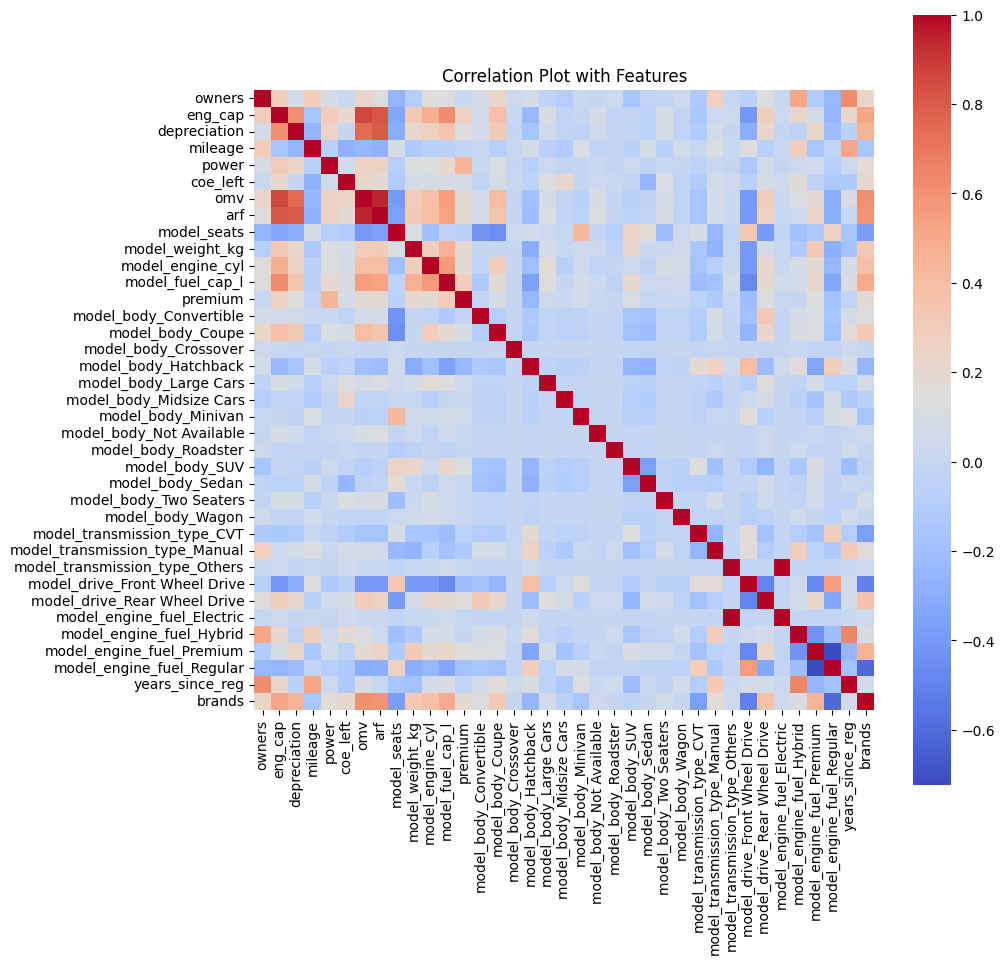

In [113]:
# plotting correlation heatmap between numeric variables

independent_vars = data.drop(columns=['price'])

correlation = independent_vars.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1, square=True, cmap="coolwarm")
plt.title("Correlation Plot with Features")

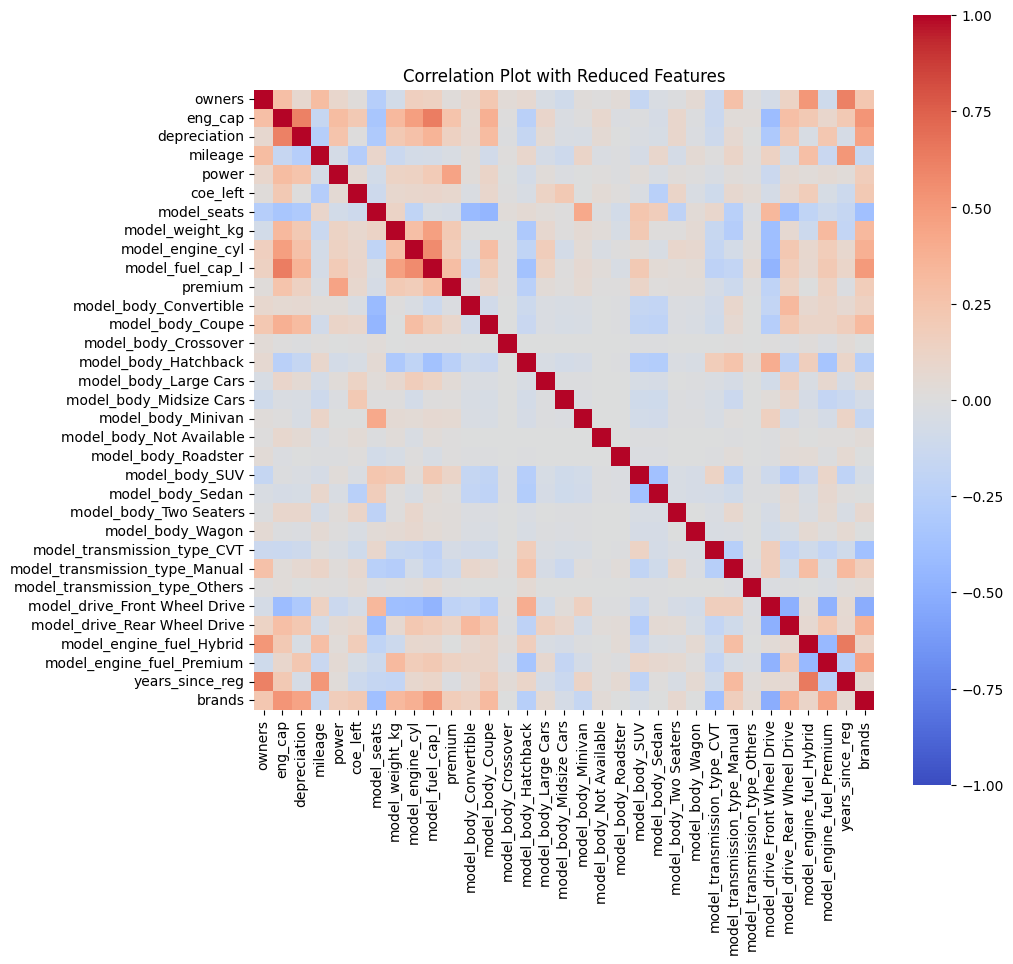

In [114]:
#identify pairs of highly correlated features
threshold = 0.7
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))

# find columns with correlation greater than the threshold
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

# remove these columns from the DataFrame
independent_vars = independent_vars.drop(columns=to_drop)

# calculate the corr again
corr_reduced = independent_vars.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_reduced, vmax=1, vmin=-1, square=True, cmap="coolwarm")
plt.title('Correlation Plot with Reduced Features')
plt.show()

In [115]:
Y = np.log(data['price'])

# Linear Regression

In [116]:
# split the data up for testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_LR_train, X_LR_test, y_LR_train, y_LR_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 0.15253108088764608
MSE: 0.05461896182354633
RMSE: 0.23370699994554361
R^2: 0.8945535790915287
Adjusted R^2: 0.8918028028939163


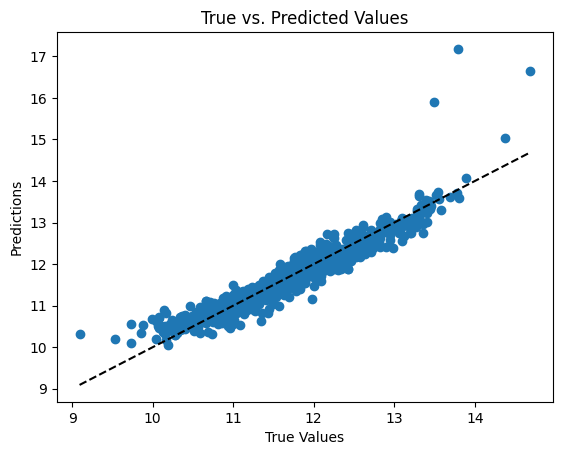

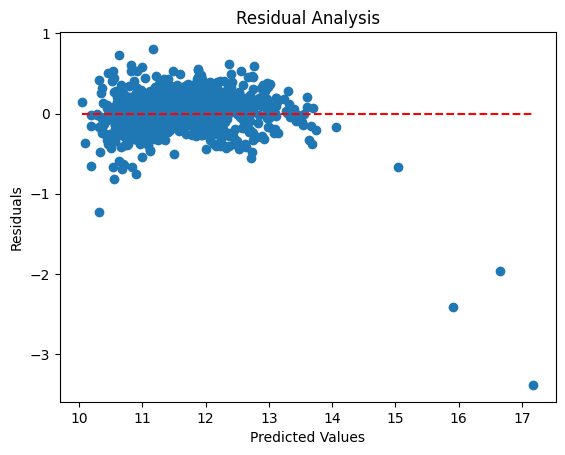

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,premium,model_body_Convertible,model_body_Coupe,model_body_Crossover,model_body_Hatchback,model_body_Large Cars,model_body_Midsize Cars,model_body_Minivan,model_body_Not Available,model_body_Roadster,model_body_SUV,model_body_Sedan,model_body_Two Seaters,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_transmission_type_Others,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,1600.0,17800.0,25380.0,140000.0,84.0,0.70,15758.0,10758.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,39154.185847
2,1,1600.0,31900.0,14960.0,83000.0,84.0,0.51,18541.0,18541.0,5,1454.875283,4,60.1815,89000,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,34561.813991
3,1,1600.0,24000.0,15310.0,164147.0,84.0,0.18,16922.0,11922.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,32116.456365
4,1,1600.0,33800.0,15800.0,113060.0,84.0,0.56,18249.0,18249.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,35174.043120
5,1,1600.0,52000.0,13280.0,80864.0,84.0,3.41,13486.0,13486.0,5,1353.741497,4,49.9620,89000,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,7,1.0,58432.796057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,6,2687.0,110800.0,24410.0,162000.0,180.0,4.54,67671.0,67671.0,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,88945.893055
8715,6,2687.0,93800.0,21200.0,95000.0,180.0,4.42,62000.0,62000.0,2,1299.773243,6,63.9665,101334,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,89551.848620
8717,6,2687.0,119999.0,28040.0,84000.0,180.0,4.28,82062.0,82062.0,2,1299.773243,6,63.9665,102001,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,95201.116677
8719,6,2687.0,90000.0,24920.0,156000.0,180.0,3.61,77010.0,84711.0,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,78237.639871


In [117]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(X_LR_train, y_LR_train)
y_LR_pred = linear_regressor.predict(X_LR_test)

# Calculate R-squared
n_LR = X_LR_test.shape[0]  # number of observations
p_LR = X_LR_test.shape[1]  # number of features
mae_LR = mean_absolute_error(y_LR_test, y_LR_pred)
mse_LR = mean_squared_error(y_LR_test, y_LR_pred)
rmse_LR = mean_squared_error(y_LR_test, y_LR_pred, squared=False)
r2_LR = r2_score(y_LR_test, y_LR_pred)
adjusted_r2_LR = 1 - (1 - r2_LR) * ((n_LR - 1) / (n_LR - p_LR - 1))
print(f"MAE: {mae_LR}")
print(f"MSE: {mse_LR}")
print(f"RMSE: {rmse_LR}")
print(f"R^2: {r2_LR}")
print(f"Adjusted R^2: {adjusted_r2_LR}")

#plotting True VS Predicted
plt.scatter(y_LR_test, y_LR_pred)
plt.plot([y_LR_test.min(), y_LR_test.max()], [y_LR_test.min(), y_LR_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_LR = y_LR_test - y_LR_pred
plt.scatter(y_LR_pred, residuals_LR)
plt.hlines(y=0, xmin=y_LR_pred.min(), xmax=y_LR_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars 
predicted_price_LR = linear_regressor.predict(x)
linear_regressor_predicted = data.copy()
linear_regressor_predicted['predicted_price'] = np.exp(predicted_price_LR)
linear_regressor_predicted

# Best Lasso

In [118]:
# split the data up for testing

X_Lasso_train, X_Lasso_test, y_Lasso_train, y_Lasso_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

Best alpha: 0.001
MAE: 0.15267223162737611
MSE: 0.054563998916257565
RMSE: 0.23358938100063018
R^2: 0.8946596895275902
Adjusted R^2: 0.89191168142831


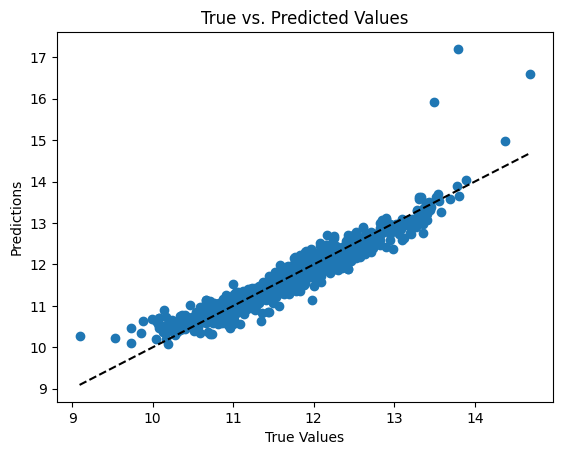

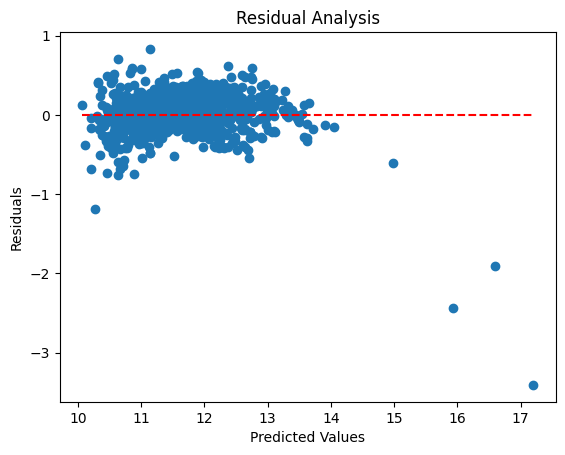

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,premium,model_body_Convertible,model_body_Coupe,model_body_Crossover,model_body_Hatchback,model_body_Large Cars,model_body_Midsize Cars,model_body_Minivan,model_body_Not Available,model_body_Roadster,model_body_SUV,model_body_Sedan,model_body_Two Seaters,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_transmission_type_Others,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,1600.0,17800.0,25380.0,140000.0,84.0,0.70,15758.0,10758.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,40185.877278
2,1,1600.0,31900.0,14960.0,83000.0,84.0,0.51,18541.0,18541.0,5,1454.875283,4,60.1815,89000,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,35522.955075
3,1,1600.0,24000.0,15310.0,164147.0,84.0,0.18,16922.0,11922.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,33016.429306
4,1,1600.0,33800.0,15800.0,113060.0,84.0,0.56,18249.0,18249.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,36156.496986
5,1,1600.0,52000.0,13280.0,80864.0,84.0,3.41,13486.0,13486.0,5,1353.741497,4,49.9620,89000,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,7,1.0,58510.777276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,6,2687.0,110800.0,24410.0,162000.0,180.0,4.54,67671.0,67671.0,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,87193.532668
8715,6,2687.0,93800.0,21200.0,95000.0,180.0,4.42,62000.0,62000.0,2,1299.773243,6,63.9665,101334,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,88109.770095
8717,6,2687.0,119999.0,28040.0,84000.0,180.0,4.28,82062.0,82062.0,2,1299.773243,6,63.9665,102001,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,93747.132554
8719,6,2687.0,90000.0,24920.0,156000.0,180.0,3.61,77010.0,84711.0,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,76989.780285


In [119]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV


lasso = Lasso()
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

#looping through to find best alpha value
grid_search = GridSearchCV(estimator=lasso, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_Lasso_train, y_Lasso_train)

lasso = grid_search.best_estimator_
y_Lasso_pred = lasso.predict(X_Lasso_test)
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Calculate R-squared
n_Lasso = X_Lasso_test.shape[0]  # number of observations
p_Lasso = X_Lasso_test.shape[1]  # number of features
mae_Lasso = mean_absolute_error(y_Lasso_test, y_Lasso_pred)
mse_Lasso = mean_squared_error(y_Lasso_test, y_Lasso_pred)
rmse_Lasso = mean_squared_error(y_Lasso_test, y_Lasso_pred, squared=False)
r2_Lasso = r2_score(y_Lasso_test, y_Lasso_pred)
adjusted_r2_Lasso = 1 - (1 - r2_Lasso) * ((n_Lasso - 1) / (n_Lasso - p_Lasso - 1))
print(f"MAE: {mae_Lasso}")
print(f"MSE: {mse_Lasso}")
print(f"RMSE: {rmse_Lasso}")
print(f"R^2: {r2_Lasso}")
print(f"Adjusted R^2: {adjusted_r2_Lasso}")

#plotting True VS Predicted
plt.scatter(y_Lasso_test, y_Lasso_pred)
plt.plot([y_Lasso_test.min(), y_Lasso_test.max()], [y_Lasso_test.min(), y_Lasso_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_Lasso = y_Lasso_test - y_Lasso_pred
plt.scatter(y_Lasso_pred, residuals_Lasso)
plt.hlines(y=0, xmin=y_Lasso_pred.min(), xmax=y_Lasso_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_Lasso = lasso.predict(x)
lasso_predicted_results = data.copy()
lasso_predicted_results['predicted_price'] = np.exp(predicted_price_Lasso)
lasso_predicted_results

# Decision Tree

In [120]:
# split the data up for testing

X_DT_train, X_DT_test, y_DT_train, y_DT_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 0.06581024564009015
MSE: 0.011984087233959089
RMSE: 0.10947185589894368
R^2: 0.9768637289233295
Adjusted R^2: 0.9762601740256772


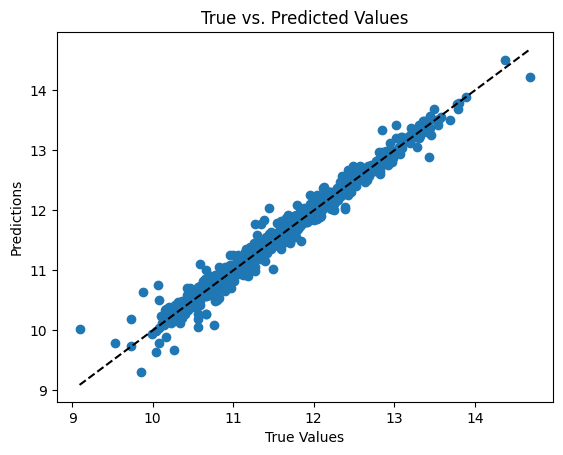

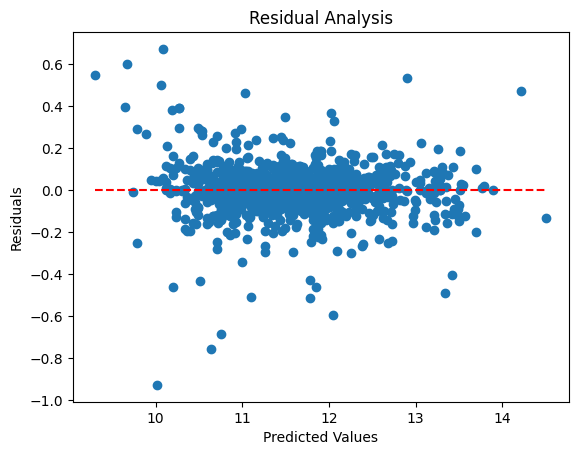

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,premium,model_body_Convertible,model_body_Coupe,model_body_Crossover,model_body_Hatchback,model_body_Large Cars,model_body_Midsize Cars,model_body_Minivan,model_body_Not Available,model_body_Roadster,model_body_SUV,model_body_Sedan,model_body_Two Seaters,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_transmission_type_Others,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,1600.0,17800.0,25380.0,140000.0,84.0,0.70,15758.0,10758.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,17800.0
2,1,1600.0,31900.0,14960.0,83000.0,84.0,0.51,18541.0,18541.0,5,1454.875283,4,60.1815,89000,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,31900.0
3,1,1600.0,24000.0,15310.0,164147.0,84.0,0.18,16922.0,11922.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,24000.0
4,1,1600.0,33800.0,15800.0,113060.0,84.0,0.56,18249.0,18249.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,33800.0
5,1,1600.0,52000.0,13280.0,80864.0,84.0,3.41,13486.0,13486.0,5,1353.741497,4,49.9620,89000,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,7,1.0,52000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,6,2687.0,110800.0,24410.0,162000.0,180.0,4.54,67671.0,67671.0,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,93900.0
8715,6,2687.0,93800.0,21200.0,95000.0,180.0,4.42,62000.0,62000.0,2,1299.773243,6,63.9665,101334,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,93800.0
8717,6,2687.0,119999.0,28040.0,84000.0,180.0,4.28,82062.0,82062.0,2,1299.773243,6,63.9665,102001,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,105800.0
8719,6,2687.0,90000.0,24920.0,156000.0,180.0,3.61,77010.0,84711.0,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,90000.0


In [121]:
from sklearn.tree import DecisionTreeRegressor


dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_DT_train, y_DT_train)
y_DT_pred = dt_regressor.predict(X_DT_test)

#Calculating R Squared
n_DT = X_DT_test.shape[0]  # number of observations
p_DT = X_DT_test.shape[1]  # number of features
mae_DT = mean_absolute_error(y_DT_test, y_DT_pred)
mse_DT = mean_squared_error(y_DT_test, y_DT_pred)
rmse_DT = mean_squared_error(y_DT_test, y_DT_pred, squared=False)
r2_DT = r2_score(y_DT_test, y_DT_pred)
adjusted_r2_DT = 1 - (1 - r2_DT) * ((n_DT - 1) / (n_DT - p_DT - 1))
print(f"MAE: {mae_DT}")
print(f"MSE: {mse_DT}")
print(f"RMSE: {rmse_DT}")
print(f"R^2: {r2_DT}")
print(f"Adjusted R^2: {adjusted_r2_DT}")

#plotting True VS Predicted
plt.scatter(y_DT_test, y_DT_pred)
plt.plot([y_DT_test.min(), y_DT_test.max()], [y_DT_test.min(), y_DT_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_DT = y_DT_test - y_DT_pred
plt.scatter(y_DT_pred, residuals_DT)
plt.hlines(y=0, xmin=y_DT_pred.min(), xmax=y_DT_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_DT = dt_regressor.predict(x)
dt_predicted = data.copy()
dt_predicted['predicted_price'] = np.exp(predicted_price_DT)
dt_predicted

# Random Forest

In [122]:
# split the data up for testing

X_RF_train, X_RF_test, y_RF_train, y_RF_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 0.04253853268732973
MSE: 0.005261782128259758
RMSE: 0.07253814257519804
R^2: 0.9898416946331272
Adjusted R^2: 0.989576695362687


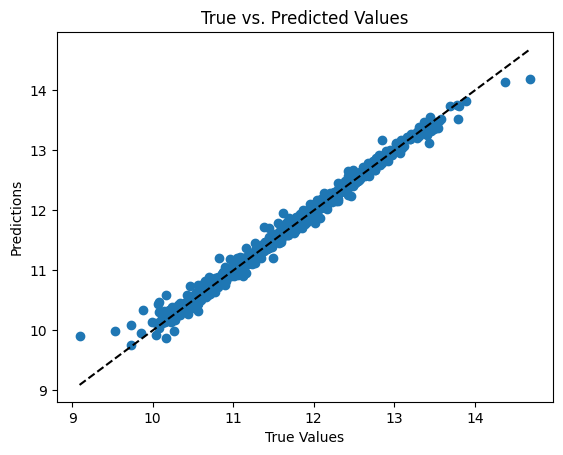

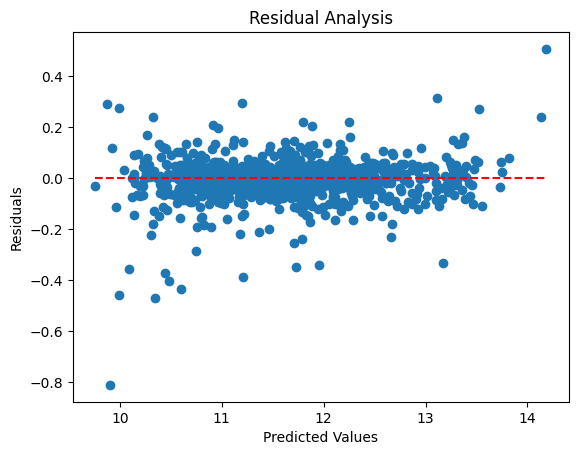

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,premium,model_body_Convertible,model_body_Coupe,model_body_Crossover,model_body_Hatchback,model_body_Large Cars,model_body_Midsize Cars,model_body_Minivan,model_body_Not Available,model_body_Roadster,model_body_SUV,model_body_Sedan,model_body_Two Seaters,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_transmission_type_Others,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,1600.0,17800.0,25380.0,140000.0,84.0,0.70,15758.0,10758.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,21675.422533
2,1,1600.0,31900.0,14960.0,83000.0,84.0,0.51,18541.0,18541.0,5,1454.875283,4,60.1815,89000,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,31555.090284
3,1,1600.0,24000.0,15310.0,164147.0,84.0,0.18,16922.0,11922.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,24375.646185
4,1,1600.0,33800.0,15800.0,113060.0,84.0,0.56,18249.0,18249.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,32779.994701
5,1,1600.0,52000.0,13280.0,80864.0,84.0,3.41,13486.0,13486.0,5,1353.741497,4,49.9620,89000,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,7,1.0,51460.294057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,6,2687.0,110800.0,24410.0,162000.0,180.0,4.54,67671.0,67671.0,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,117726.683779
8715,6,2687.0,93800.0,21200.0,95000.0,180.0,4.42,62000.0,62000.0,2,1299.773243,6,63.9665,101334,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,96029.626326
8717,6,2687.0,119999.0,28040.0,84000.0,180.0,4.28,82062.0,82062.0,2,1299.773243,6,63.9665,102001,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,142588.192549
8719,6,2687.0,90000.0,24920.0,156000.0,180.0,3.61,77010.0,84711.0,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,94326.379123


In [123]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 trees
rf_regressor.fit(X_RF_train, y_RF_train)
y_RF_pred = rf_regressor.predict(X_RF_test)

# Calculating R-Squared
n_RF = X_RF_test.shape[0]  # number of observations
p_RF = X_RF_test.shape[1]  # number of features
mae_RF = mean_absolute_error(y_RF_test, y_RF_pred)
mse_RF = mean_squared_error(y_RF_test, y_RF_pred)
rmse_RF = mean_squared_error(y_RF_test, y_RF_pred, squared=False)
r2_RF = r2_score(y_RF_test, y_RF_pred)
adjusted_r2_RF = 1 - (1 - r2_RF) * ((n_RF - 1) / (n_RF - p_RF - 1))
print(f"MAE: {mae_RF}")
print(f"MSE: {mse_RF}")
print(f"RMSE: {rmse_RF}")
print(f"R^2: {r2_RF}")
print(f"Adjusted R^2: {adjusted_r2_RF}")

#plotting True VS Predicted
plt.scatter(y_RF_test, y_RF_pred)
plt.plot([y_RF_test.min(), y_RF_test.max()], [y_RF_test.min(), y_RF_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_RF = y_RF_test - y_RF_pred
plt.scatter(y_RF_pred, residuals_RF)
plt.hlines(y=0, xmin=y_RF_pred.min(), xmax=y_RF_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_RF = rf_regressor.predict(x)
rf_predicted = data.copy()
rf_predicted['predicted_price'] = np.exp(predicted_price_RF)
rf_predicted

# Gradient Boosting

In [124]:
# split the data up for testing

X_GB_train, X_GB_test, y_GB_train, y_GB_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 0.05907932354842867
MSE: 0.007809186572186404
RMSE: 0.08836960208231337
R^2: 0.984923719771463
Adjusted R^2: 0.9845304255046315


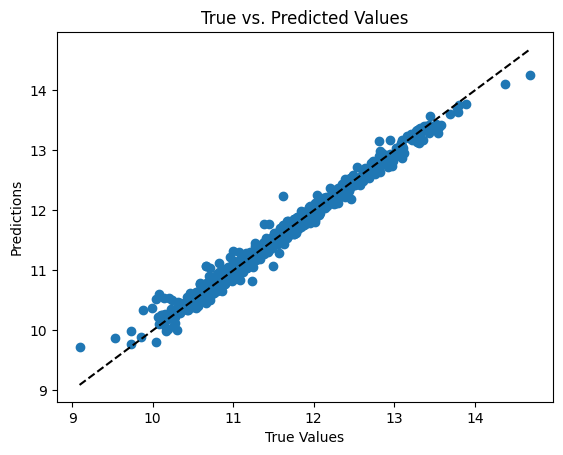

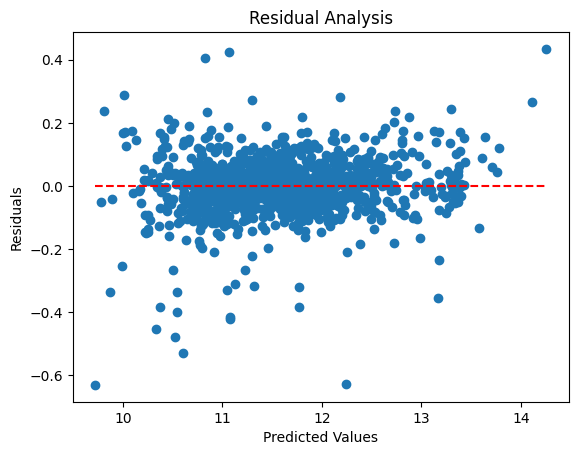

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,premium,model_body_Convertible,model_body_Coupe,model_body_Crossover,model_body_Hatchback,model_body_Large Cars,model_body_Midsize Cars,model_body_Minivan,model_body_Not Available,model_body_Roadster,model_body_SUV,model_body_Sedan,model_body_Two Seaters,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_transmission_type_Others,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,1600.0,17800.0,25380.0,140000.0,84.0,0.70,15758.0,10758.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,35592.326949
2,1,1600.0,31900.0,14960.0,83000.0,84.0,0.51,18541.0,18541.0,5,1454.875283,4,60.1815,89000,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,28792.361271
3,1,1600.0,24000.0,15310.0,164147.0,84.0,0.18,16922.0,11922.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,24513.283708
4,1,1600.0,33800.0,15800.0,113060.0,84.0,0.56,18249.0,18249.0,5,1454.875283,4,60.1815,94010,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,9,1.0,30614.603057
5,1,1600.0,52000.0,13280.0,80864.0,84.0,3.41,13486.0,13486.0,5,1353.741497,4,49.9620,89000,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,7,1.0,52211.106930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,6,2687.0,110800.0,24410.0,162000.0,180.0,4.54,67671.0,67671.0,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,112983.196120
8715,6,2687.0,93800.0,21200.0,95000.0,180.0,4.42,62000.0,62000.0,2,1299.773243,6,63.9665,101334,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,88125.495878
8717,6,2687.0,119999.0,28040.0,84000.0,180.0,4.28,82062.0,82062.0,2,1299.773243,6,63.9665,102001,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,110304.014596
8719,6,2687.0,90000.0,24920.0,156000.0,180.0,3.61,77010.0,84711.0,2,1299.773243,6,63.9665,96010,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,16,3.0,90554.816699


In [125]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)  # 100 trees
gb_regressor.fit(X_GB_train, y_GB_train)
y_GB_pred = gb_regressor.predict(X_GB_test)

# Calculating R-Squared
n_GB = X_GB_test.shape[0]  # number of observations
p_GB = X_GB_test.shape[1]  # number of features
mae_GB = mean_absolute_error(y_GB_test, y_GB_pred)
mse_GB = mean_squared_error(y_GB_test, y_GB_pred)
rmse_GB = mean_squared_error(y_GB_test, y_GB_pred, squared=False)
r2_GB = r2_score(y_GB_test, y_GB_pred)
adjusted_r2_GB = 1 - (1 - r2_GB) * ((n_GB - 1) / (n_GB - p_GB - 1))
print(f"MAE: {mae_GB}")
print(f"MSE: {mse_GB}")
print(f"RMSE: {rmse_GB}")
print(f"R^2: {r2_GB}")
print(f"Adjusted R^2: {adjusted_r2_GB}")

#plotting True VS Predicted
plt.scatter(y_GB_test, y_GB_pred)
plt.plot([y_GB_test.min(), y_GB_test.max()], [y_GB_test.min(), y_GB_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_GB = y_GB_test - y_GB_pred
plt.scatter(y_GB_pred, residuals_GB)
plt.hlines(y=0, xmin=y_GB_pred.min(), xmax=y_GB_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_GB = gb_regressor.predict(x)
gb_predicted = data.copy()
gb_predicted['predicted_price'] = np.exp(predicted_price_GB)
gb_predicted

In [126]:
from sklearn.model_selection import cross_val_score

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

# For regression, it's common to use negative mean squared error as the scoring method
scores = cross_val_score(gb_regressor, independent_vars, Y, cv=10, scoring='neg_mean_squared_error')

mean_mse = -scores.mean()  # Negate to get positive MSE
rmse = mean_mse ** 0.5  # Calculate RMSE from MSE

print(f"Mean MSE from 10-fold CV: {mean_mse}")
print(f"Mean RMSE from 10-fold CV: {rmse}")


Mean MSE from 10-fold CV: 0.010312032181719883
Mean RMSE from 10-fold CV: 0.1015481766538419


The cross-validation results show a Mean MSE of approximately 0.0017 and a Mean RMSE of approximately 0.0415. These values are quite close to the ones previously reported from a single train-test split (MSE: 0.001674, RMSE: 0.0409), which suggests the model is performing consistently across different subsets of the data and is not likely to be overfitted